### Como acompanhar?

No binder, abra uma nova aba e selecione o terminal, no terminal digite:

```bash
cd
cd src/datomic-pro-1.0.7394/
bin/transactor config/samples/dev-transactor-template.properties 
```
E espere o sistema devolver:
```
System started
```

Se quiser pode fechar essa aba agora!

Certo... O que eu acabei de fazer?

Datomic é um banco de dados **distribuído**, sendo assim, ele separa a reponsabilidade de diferentes funções para diferentes processos.

O que você acabou de fazer foi lançar um **transactor** que, como o nome diz, é responsável por controlar as transações. 

<img width="50%" src=attachment:5041c509-b9de-40f9-bf74-2c49b0adb899.png>
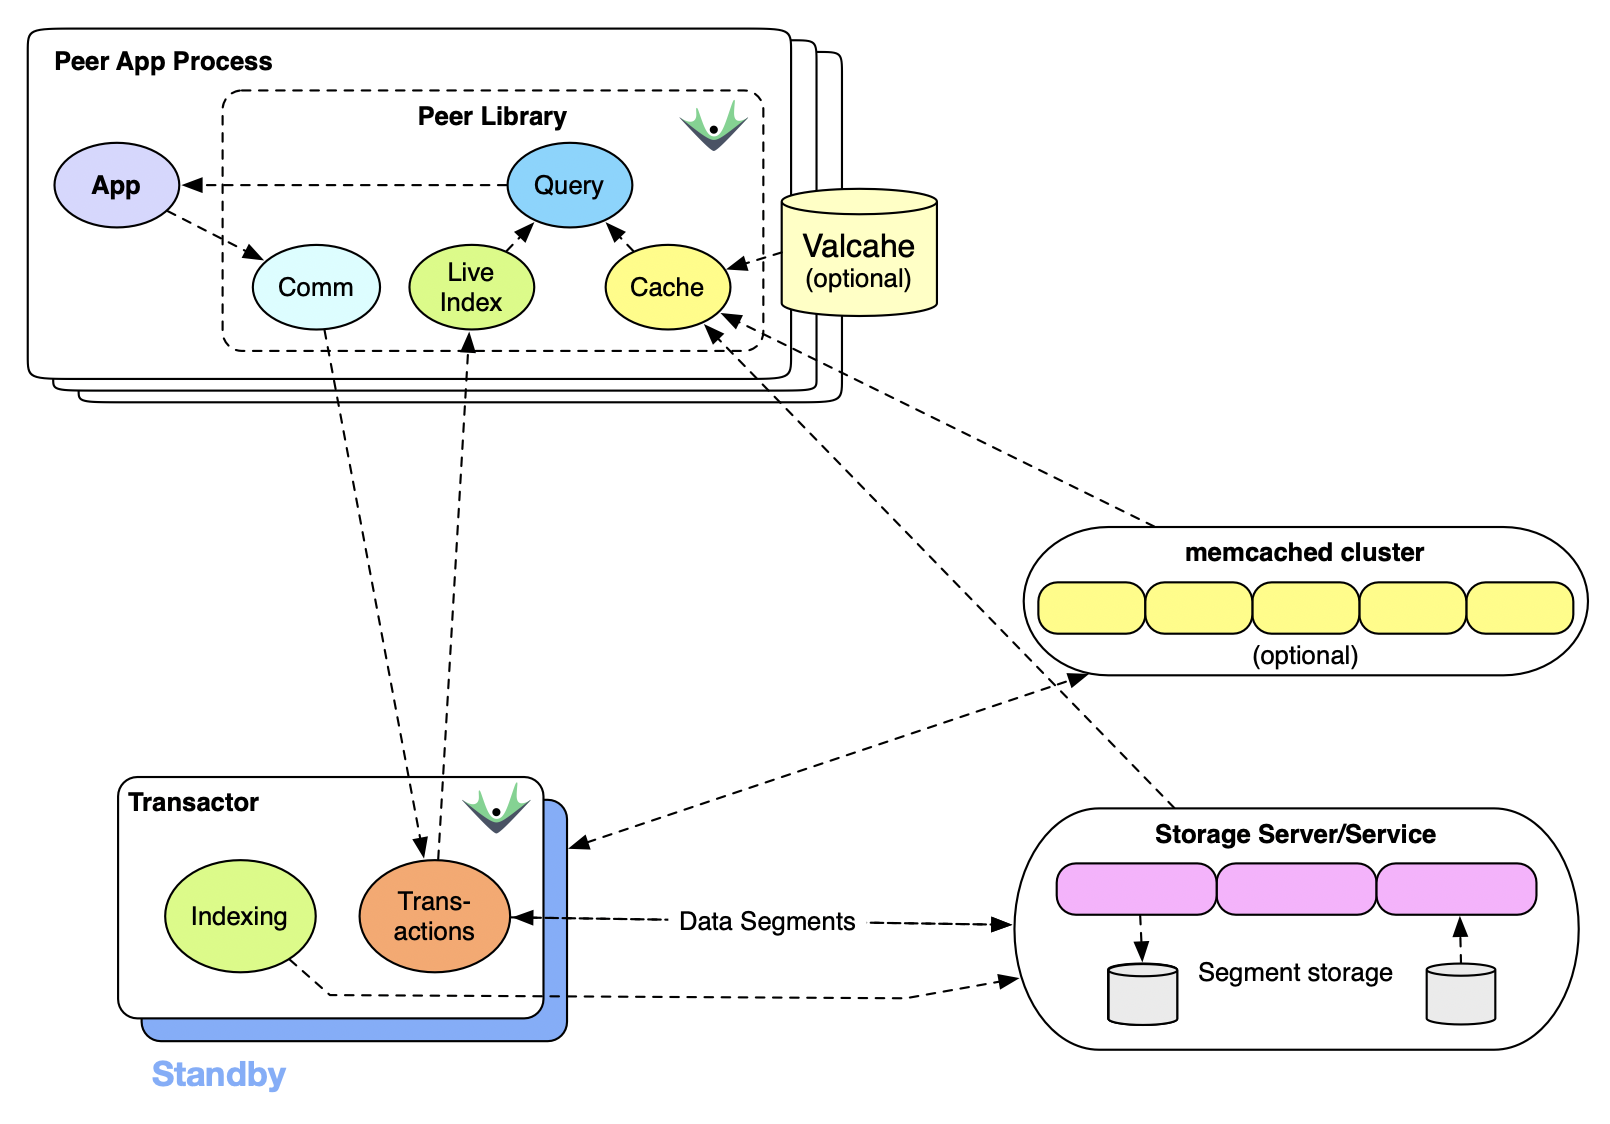

Agora vamos importar algumas bibliotecas importantes:
* `clojupyter.misc.helper`: um helper para o nosso kernel de Clojure no Jupyter, não importa muito... Ele só será utilizado aqui para acrescentar o `com.datomic/peer` como depedência;
* `clojure.pprint`: um Pretty Printer;
* `datomic.api`: A `peer` api para comunicar com o `transactor` e o `armazenamento`.

Basta computar o bloco a seguir, você pode clicar no bloco e:
* Apertar no botão de play acima;
* Apertar ctrl+enter;
* Apertar shift+enter.

In [ ]:
(require '[clojupyter.misc.helper :as helper]
         '[clojure.pprint :as pp])

(helper/add-dependencies '[com.datomic/peer "1.0.7394"])

(require '[datomic.api :as d])

Por fim, vamos criar nosso banco de dados:

Primeiramente definimos uma uri

In [ ]:
(def db-uri "datomic:dev://localhost:4334/mini-gde")

Agora criamos um novo banco de dados nessa uri:

In [ ]:
(d/create-database db-uri)

Agora conectamos ao banco de dados. 

A função que cria a conexão também a retorna, pois tudo é DADO! 

Sendo assim, vinculamos o símbolo `conn` ao retorno da função `d/connect` aplicada ao valor do símbolo `db-uri`

<img width="33%" src=attachment:e91a2706-1abd-42a2-bbf0-5574801018bd.png>

Em outras palavras, definimos uma variável `conn` que possui como valor um objeto que representa a conexão com nosso banco de dados
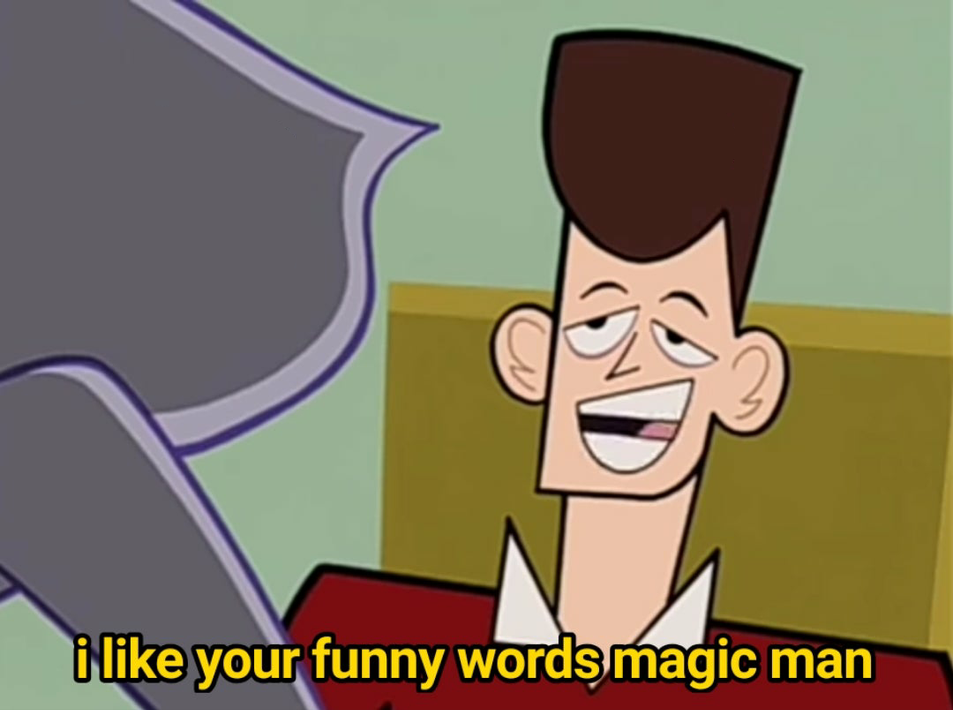

In [ ]:
(def conn (d/connect db-uri))

### Schema

Vamos fazer, juntos, um mini (bem mini mesmo) gde em Datomic!

Inicialmente nós construimos um (ou mais) `schema`(s) que será responsável por ditar a estrutura dos nossos dados! 

In [ ]:
(def schema [;; ID do professor
             {:db/ident       :professor/id
              :db/valueType   :db.type/uuid
              :db/cardinality :db.cardinality/one
              :db/unique      :db.unique/identity}
             ;; Nome do professor
             {:db/ident       :professor/nome
              :db/valueType   :db.type/string
              :db/cardinality :db.cardinality/one}
             ;; Disciplinas que o professor está lecionando
             {:db/ident       :professor/disciplinas
              :db/valueType   :db.type/ref           ; Referência ao que? Cabe a aplicação decidir!
              :db/cardinality :db.cardinality/many}
             ;; Id da disciplina
             {:db/ident       :disciplina/id
              :db/valueType   :db.type/uuid
              :db/cardinality :db.cardinality/one
              :db/unique      :db.unique/value}
             ;; Nome da disciplina
             {:db/ident       :disciplina/nome
              :db/valueType   :db.type/string
              :db/cardinality :db.cardinality/one}
             ;; Código da disciplina
             {:db/ident       :disciplina/codigo
              :db/valueType   :db.type/ref
              :db/cardinality :db.cardinality/one
              :db/unique      :db.unique/value}
             ;; Enum de disciplinas
             {:db/ident       :disciplina.codigo/MC346}
             {:db/ident       :disciplina.codigo/MC536}
             {:db/ident       :disciplina.codigo/MC750}
             {:db/ident       :disciplina.codigo/outro}])

### Pergunta
Como podemos adicionar nosso `schema` ao nosso banco de dados?

In [ ]:
(def tx-log @(d/transact conn schema))

Vamos analisar o que a transação `d/transact` retornou para nós:

In [ ]:
(pp/pprint tx-log)

Veja que um transação retorna um mapa com 4 chave/valor:
* `:db-before`: o estado do banco de dados antes da transação;
* `:db-after`: o estado do banco de dados depois da transação;
* `:tx-data`: um vetor com cada `datom` que foi transacionado;
* `:tempids`: um mapa que relaciona `id` temporário e `id` da entidade, são utilizados para entidades as quais o usuário não conhece ou não se importa com o id.

Vamos analisar o `:tx-data` com mais profundidade:

In [ ]:
(-> tx-log
    :tx-data
    (as-> q
        (doseq [e q]
            (println "->" e))))

Quando dizemos que tudo é **dado** não é brincadeira.

Por exemplo, a **consulta** a seguir retorna dados sobre um **schema**:

In [ ]:
(->> (d/q '[:find  [(pull ?e [* {:db/valueType          [:db/ident]
                                 :db/cardinality        [:db/ident]
                                 :db.install/_attribute [:db/ident]}])]
           :where [?e :db/ident :professor/disciplinas]]
         (d/db conn))
    first
    pp/pprint)

### Adicionando entidades

Existem duas maneiras de se adicionar novas entidades no datomic:
* com mapas, indicando diretamente a entidade a ser adicionada;
* com vetores, sendo cada vetor uma instrução `:db/add`, `:db/retract` ou qualquer função definida pelo usuário!

##### **NOTA**: Lembre-se que uma transação no datomic ocorre **sempre** de maneira **estritamente serial**, sendo assim, utilizar funções definidas por você pode causar grande lentidão em uma transação.   

#### Utilizando mapas

In [ ]:
;;  UUID semi sequencial, mais performático que `uuid` v4.
(def professor-id (d/squuid))
(def mc536-id (d/squuid))

(def tx-log @(d/transact conn [{:professor/id   professor-id
                                :professor/nome "Emanuel"
                                :professor/disciplinas 
                                [{:db/id             "E" ; tempid
                                  :disciplina/id     mc536-id
                                  :disciplina/codigo :disciplina.codigo/MC536
                                  :disciplina/nome   "Bancos de Dados: Prática e Teoria"}]}]))

In [ ]:
(-> tx-log
    :tempids
    pp/pprint)

In [ ]:
(-> tx-log
    :tx-data
    (as-> q
        (doseq [e q]
            (println "->" e))))

Acima nós adicionamos o professor Emanuel e a disciplina MC536.

Além disso adicionamos uma referência a MC536 na lista de disciplinas (`:professor/disciplinas`) do professor Emanuel

#### Utilizando vetores

O nome da disciplinina MC536 está errado, o correto é "Banco de dados: Teoria e Prática".

Além disso, o professor Emanuel também leciona disciplina MC750 "Construção de Interfaces **Homem**-Computador" (que nome hein...).

Vamos criar uma transação que:
1. altera o nome da disciplina MC536;
2. adiciona a disciplina MC750 a lista de disciplinas que o professor Emanual leciona.

In [ ]:
(def tx-log @(d/transact conn [;; Altera o nome da disciplina MC536
                               [:db/add [:disciplina/id mc536-id] :disciplina/nome "Banco de Dados: Teoria e Prática"]
                               ;; Adiciona a disciplina MC750
                               [:db/add "IHC" :disciplina/id (d/squuid)]
                               [:db/add "IHC" :disciplina/codigo :disciplina.codigo/MC750]
                               [:db/add "IHC" :disciplina/nome "Construção de Interfaces Homem-Computador"]
                               ;; Adiciona a disciplina MC750 a lista de disciplinas que o professor Emanuel leciona
                               [:db/add [:professor/id professor-id] :professor/disciplinas "IHC"]]))

In [ ]:
(-> tx-log
    :tempids
    pp/pprint)

In [ ]:
(-> tx-log
    :tx-data
    (as-> q
        (doseq [e q]
            (println "->" e))))

### Consulta

Para finalizar, vamos fazer algumas consultas.

Uma consulta também bode ser feita em duas formas: vetor ou mapa.

#### Utilizando vetores

In [ ]:
(def db (d/db conn))
    
(d/q '[:find ?disciplinas
       :where
       [?professor :professor/nome "Emanuel"]
       [?professor :professor/disciplinas ?disciplinas]]
     db)

#### Utilizando mapas

Veja que a busca acima retornou duas referências a duas disciplinas, mas esse dado não é muito legível para nós...

Podemos utilizar a função `pull` para estruturar os dados.

A função `pull` faz uma busca em grafos utilizando as estruturas primitivas do clojure `vetor []` e `mapas {}`: 

In [ ]:
(-> (d/q '{:find  [(pull ?professor [:professor/nome 
                                     {:professor/disciplinas 
                                      [:disciplina/nome 
                                       {:disciplina/codigo [*]}]}])]
           :where [[?disciplina :disciplina/codigo     :disciplina.codigo/MC536]
                   [?professor  :professor/disciplinas ?disciplina]]}
         db)
    pp/pprint)

Perceba que a busca acima retorna uma lista de listas, pois o datomic não sabe que existe somente o professor Emanuel em nosso banco.

Como esse conhecimento deve partir do usuário, dentro de um `pull` nós podemos utilizar um outro formato. 

Podemos utilizar um "vinculador" de coleções, em outras palavras, podemos adicionar um `vetor []` a cláusula `:find` indicando qual símbolo deve ser associado ao resultado.

... COMO ASSIM?

Veja:

In [ ]:
(-> (d/q '[:find  ?professor
           :where [?disciplina :disciplina/codigo     :disciplina.codigo/MC536]
                  [?professor  :professor/disciplinas ?disciplina]]
         db)
    pp/pprint)

In [ ]:
(-> (d/q '[:find  [?professor]
           :where [?disciplina :disciplina/codigo     :disciplina.codigo/MC536]
                  [?professor  :professor/disciplinas ?disciplina]]
         db)
    pp/pprint)

Ou seja, associamos o símbolo `?professor` ao **primeiro** elemento retornado pela consulta.

##### Lembrando que a ordem de retorno de uma busca é não deterministica (é um hash-set), ou seja, o primeiro elemento pode não ser o mesmo para outros estados do banco de dados. 

Por fim, podemos usar esse "vinculador" junto ao pull:

In [ ]:
(-> (d/q '[:find  [(pull ?professor [:professor/nome 
                                     {:professor/disciplinas 
                                      [:disciplina/nome
                                       {:disciplina/codigo [:db/ident]}]}])] 
           :where [?disciplina :disciplina/codigo     :disciplina.codigo/MC536]
                  [?professor  :professor/disciplinas ?disciplina]]
         db)
    pp/pprint)